Test case: using on-axis scattering and our classics code for Compton spectrum calculation (https://github.com/maxbalrog/Compton_scattering_classic), for a fixed $(a_0, \tau)$ pair try to optimize $\beta$ parameter in laser pulse with gauss_spectral temporal envelope so that the spectra will have the highest photon peak.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 2

import optuna
from optuna.visualization import plot_optimization_history

from ComptonSpec_classic import Trajectory, Spectrum
from utils_simulation import *

SEED = 33
np.random.seed(SEED)

In [2]:
u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

# Laser pulse parameters
tau = 2 * np.pi    # Pulse duration
a0 = 1             # Pulse amplitude
mode = 'gauss_spectral'   # Temporal envelope
beta = 4            # Chirp parameter
polarization = 'circular'

# Define laser phase grid and calculate vector potential
eta_b = 4.4*tau*np.sqrt(1+beta**2)
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta, mode, tau, a0, beta)
u, r = traj.calc_u_x(A, eta)

# Calculate spectrum
spec = Spectrum(eta, u, r)

theta = np.pi
phi = 0
I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)

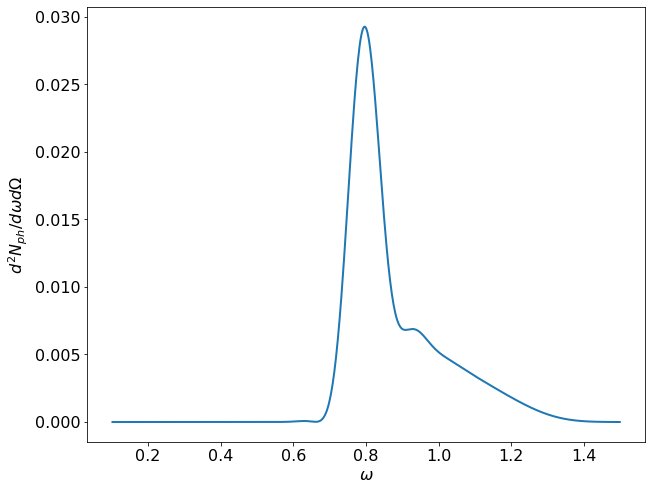

In [3]:
# Plot spectrum I(w)
w0, w1 = [0.1, 1.5]
idx = (w >= w0) & (w <= w1)
w_plot, I_plot = w[idx], I[idx]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_plot, I_plot/w_plot/137, label='numerical')
plt.xlabel('$\omega$')
plt.ylabel('$d^2 N_{ph} / d\omega d\Omega$')
plt.show()

### Optuna objective function and optuna optimization

In [4]:
# Define objective function for linear chirp optimization for a specific (a0, tau) pair
u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

mode = 'gauss_spectral'
tau = 2 * np.pi 
a0 = 2
theta = np.pi
phi = 0
wb = [0., 1.5]

def objective(trial):
    # Define range over chirp values
    beta = trial.suggest_float("beta", 0, 25)
    # Calculate spectrun for chosen beta value
    eta_b = 4.4*tau*np.sqrt(1+beta**2)
    eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
    # Calculate laser pulse vector potential and electron trajectory
    A = calc_A(eta, mode, tau=tau, a0=a0, beta=beta, polarization=polarization)
    u, r = traj.calc_u_x(A, eta)
    # Calculate Compton spectra
    spec = Spectrum(eta, u, r)
    I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)
    idx = (w > 0)
    # Transform d2 I/dw dOmega -> d2 N_ph / dw dOmega
    N_ph = I[idx] / w[idx] / 137
    w = w[idx]
    idx = (w >= wb[0]) & (w <= wb[1])
    return np.max(N_ph[idx])

In [5]:
study_name = 'chirp_optimization'
storage_name = 'sqlite:///data/optuna/{}.db'.format(study_name)
study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name, load_if_exists=True)

[I 2022-02-21 13:25:11,596] A new study created in RDB with name: chirp_optimization


In [ ]:
study.optimize(objective, n_trials=30)

[I 2022-02-21 13:25:12,569] Trial 0 finished with value: 0.22029984784933396 and parameters: {'beta': 17.204201467832068}. Best is trial 0 with value: 0.22029984784933396.
[I 2022-02-21 13:25:15,596] Trial 1 finished with value: 0.15891718726195314 and parameters: {'beta': 23.5519407512178}. Best is trial 0 with value: 0.22029984784933396.
[I 2022-02-21 13:25:16,321] Trial 2 finished with value: 0.08310321729512965 and parameters: {'beta': 5.183159781654031}. Best is trial 0 with value: 0.22029984784933396.
[I 2022-02-21 13:25:17,343] Trial 3 finished with value: 0.23584204689597696 and parameters: {'beta': 15.850065725251245}. Best is trial 3 with value: 0.23584204689597696.
[I 2022-02-21 13:25:17,519] Trial 4 finished with value: 0.026144902575044107 and parameters: {'beta': 1.662154019462034}. Best is trial 3 with value: 0.23584204689597696.
[I 2022-02-21 13:25:20,542] Trial 5 finished with value: 0.17168745579067013 and parameters: {'beta': 21.899165833789656}. Best is trial 3 with

In [ ]:
print("Best params: {}".format(study.best_params))
print("Best value: {}".format(study.best_value))

In [ ]:
folder = 'data/simulation/tau_2'
data = load_data_fixed_tau(folder)
w_a0_list, N_ph_a0_list = data[:2]
beta_arr, a0_arr, N_max_beta_a0, beta_optimal = data[2:]

In [ ]:
idx = np.where(np.isclose(a0_arr, a0))[0][0]
print(f'Optuna beta: {study.best_params}')
print(f'Simulation optimal beta: {beta_optimal[idx]}')

print(f'# of optuna trials: {len(study.trials)}')
print(f'Simulation grid length: {beta_arr.shape[0]}')

In [ ]:
plot_optimization_history(study)

In [ ]:
# Collect trial history (beta, N_ph_max)
trials = study.trials
beta_arr_optuna, N_ph_arr_optuna = [], []
for trial in trials:
    beta = trial.params['beta']
    beta_arr_optuna.append(beta)
    N = trial.values[0]
    N_ph_arr_optuna.append(N)

In [ ]:
# Plot optimization history
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(beta_arr_optuna, N_ph_arr_optuna, '.', label='optuna trials')
plt.scatter(beta_optimal[idx], np.max(N_ph_arr_optuna), color='red', marker='*', s=150, label='simulation')
plt.scatter(study.best_params['beta'], np.max(N_ph_arr_optuna), color='blue', marker='*', s=150, label='optuna')
plt.legend(loc='best')
plt.xlabel('$\\beta$')
plt.ylabel('$d N_{ph}/d\omega$')
plt.show()